In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [3]:
df = pd.read_csv('../Data/trainv2.csv')

In [21]:
df_nuevo = pd.read_csv('../Data/testv2.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980483 entries, 0 to 3980482
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   building_id             int64  
 2   meter                   int64  
 3   timestamp               object 
 4   meter_reading           float64
 5   site_id                 int64  
 6   primary_use             object 
 7   square_feet             int64  
 8   floor_count             float64
 9   air_temperature         float64
 10  cloud_coverage          float64
 11  dew_temperature         float64
 12  precip_depth_1_hr       float64
 13  sea_level_pressure      float64
 14  wind_speed              float64
 15  hour                    int64  
 16  day                     int64  
 17  weekday                 int64  
 18  building_age            float64
 19  wind_compass_direction  float64
dtypes: float64(10), int64(8), object(2)
memory usage: 607.4+ MB


<AxesSubplot:>

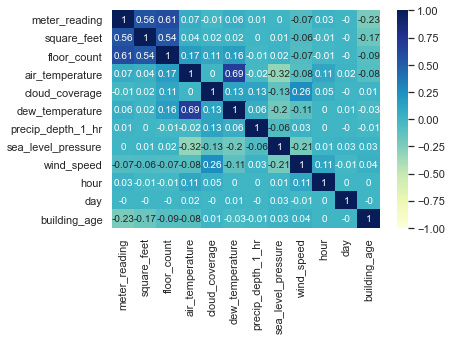

In [5]:
#Excluyo algunas variables para que sea más sencillo de leer
sns.heatmap(df.drop(["Unnamed: 0","meter","building_id","site_id","wind_compass_direction","weekday"],axis=1).corr().round(2), vmin=-1, vmax=1, center=0, cmap="YlGnBu",annot=True)

acondiciono datos de train

In [6]:
from sklearn.model_selection import train_test_split
y=df.meter_reading
X=df.drop(["Unnamed: 0","meter_reading","primary_use","meter","timestamp","floor_count"],axis=1)
X = X.fillna(method='ffill', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y)
#de la X excluyo la variable target, primary use and meter porque esán previamente filtradas, timestamp no es aplicable a este tipo de modelo,no excluyo por el momento las variables correlacionadas

acondiciono datos del test

In [22]:
df_nuevo["timestamp"] = pd.to_datetime(df_nuevo["timestamp"])

In [23]:
#X_nuevos_datos=df_nuevo.drop(["Unnamed: 0","row_id","building_id","primary_use","meter","timestamp"],axis=1)

X_nuevos_datos=df_nuevo.drop(["Unnamed: 0","row_id","primary_use","meter","timestamp","floor_count"],axis=1)
X_nuevos_datos = X_nuevos_datos.fillna(method='ffill', axis=1)

Comparacion de modelos: regresión lineal vs LightGBM Regressor

In [7]:
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return sqrt(mean_squared_error(y_valid, y_predicted))

In [64]:
from sklearn.linear_model import LinearRegression

#%%time
# creo un modelo
linear_regression = LinearRegression()
lr_rmse = fit_evaluate_model(linear_regression, X_train, y_train, X_test, y_test)
print("RMSE del modelo de regresión lineal es:", lr_rmse)

RMSE del modelo de regresión lineal es: 111.89580339823883


In [9]:
import lightgbm as lgb
categorical_features = ['site_id',"building_id",'wind_compass_direction','weekday', 'hour',"day"]
model_lgb = lgb.LGBMRegressor(objective="regression",boosting= "gbdt",metric= "rmse",num_boost_round = 1000,verbose_eval = 100)

In [11]:
model_lgb

LGBMRegressor(boosting='gbdt', metric='rmse', num_boost_round=1000,
              objective='regression', verbose_eval=100)

In [12]:
entreno = model_lgb.fit(X_train,y_train,categorical_feature=categorical_features)

In [13]:
pred = model_lgb.predict(X_train)

In [14]:
X_train.isna().sum()

building_id               0
site_id                   0
square_feet               0
air_temperature           0
cloud_coverage            0
dew_temperature           0
precip_depth_1_hr         0
sea_level_pressure        0
wind_speed                0
hour                      0
day                       0
weekday                   0
building_age              0
wind_compass_direction    0
dtype: int64

In [15]:
from sklearn import metrics

In [16]:
print ('R2:', metrics.r2_score(y_train, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

R2: 0.9763379539833946
RMSE: 21.722768607669526


In [17]:
predtest=model_lgb.predict(X_test)

In [18]:
print ('R2test:', metrics.r2_score(y_test, predtest))
print("RMSE del modelo LightGBM es:", np.sqrt(metrics.mean_squared_error(y_test, predtest)))

R2test: 0.9742342321246488
RMSE del modelo LightGBM es: 22.6867052148211


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

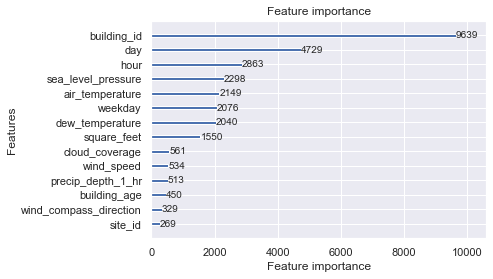

In [63]:
lgb.plot_importance(entreno)

Building_id se vuelve muy importante y reemplaza al site_id (siendo importante cuando building_id estaba comentado)

[Text(0.5, 0, 'Predichos'), Text(0, 0.5, 'Observados')]

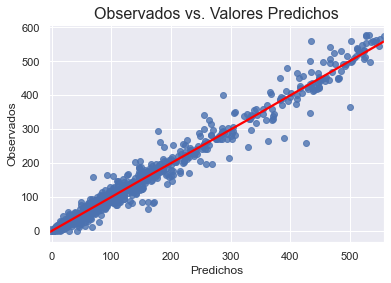

In [20]:
fig, ax = plt.subplots()

sns.regplot(x=predtest[0:1000], y=y_test[0:1000], lowess=True, line_kws={'color': 'red'})
ax.set_title('Observados vs. Valores Predichos', fontsize=16)
ax.set(xlabel='Predichos', ylabel='Observados')

Veo cmo cambia el rmse del train y validación para las iteraciones del LightGBM

In [38]:
# transformo sets train y test (validacion) en datasets de lgbm
train_dataset = lgb.Dataset(X_train, label=y_train, 
                            categorical_feature=categorical_features, 
                            free_raw_data=False)
valid_dataset = lgb.Dataset(X_test, label=y_test, 
                            categorical_feature=categorical_features, 
                            free_raw_data=False)

# guardo resultado para graficar
evals_result = {} 

# parámetos iniciales del lightGBM
initial_params = {"objective": "regression",
                  "boosting": "gbdt",
                  "num_leaves": 60,
                  "learning_rate": 0.05,
                  "feature_fraction": 0.85,
                  "reg_lambda": 2,
                  "metric": {'rmse'}
}

In [39]:
print("Construyo el modelo con las 3 cuartas partes de los datos y evalúo el modelo con el último cuarto:")
lgb_model = lgb.train(initial_params, 
                      train_set = train_dataset, 
                      num_boost_round = 1000, 
                      valid_sets=[train_dataset, valid_dataset],
                      verbose_eval = 100,
                      early_stopping_rounds = 500,
                      evals_result = evals_result)

Building model with first 3 quarter pieces and evaluating the model on the last quarter:
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 31.1106	valid_1's rmse: 31.2374
[200]	training's rmse: 27.818	valid_1's rmse: 28.0789
[300]	training's rmse: 26.375	valid_1's rmse: 26.756
[400]	training's rmse: 25.3885	valid_1's rmse: 25.8637
[500]	training's rmse: 24.6847	valid_1's rmse: 25.2437
[600]	training's rmse: 24.0007	valid_1's rmse: 24.636
[700]	training's rmse: 23.4449	valid_1's rmse: 24.1449
[800]	training's rmse: 22.9551	valid_1's rmse: 23.7155
[900]	training's rmse: 22.571	valid_1's rmse: 23.39
[1000]	training's rmse: 22.251	valid_1's rmse: 23.1212
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 22.251	valid_1's rmse: 23.1212


Errores del Training y Validation del Modelo


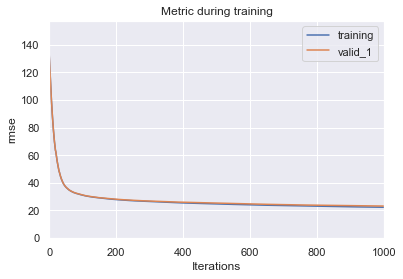

In [65]:
print('Errores del Training y Validation del Modelo')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

Validación cruzada para ver que no tenga overfitting

In [42]:
from sklearn.model_selection import KFold

# creamos un objeto kfold junto con listas vacías para modelos y evaluaciones
kf = KFold(n_splits=4, shuffle=False, random_state=42)
models = []
evaluations = []

# separo dinámicamente X e y con los índices de k-fold
for train_index,valid_index in kf.split(X):
    X_train_kf = X.loc[train_index]
    y_train_kf = y.loc[train_index]
    
    X_valid_kf = X.loc[valid_index]
    y_valid_kf = y.loc[valid_index]
    
    d_train = lgb.Dataset(X_train_kf, 
                          label=y_train_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    
    d_valid = lgb.Dataset(X_valid_kf, 
                          label=y_valid_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    evaluation_result = {}
    
    model = lgb.train(initial_params, 
                      train_set=d_train, 
                      num_boost_round=1000, 
                      valid_sets=[d_train, d_valid],
                      verbose_eval=100, 
                      early_stopping_rounds=500,
                      evals_result=evaluation_result)
    
    models.append(model)
    evaluations.append(evaluation_result)
    
    del X_train_kf, y_train_kf, X_valid_kf, y_valid_kf, d_train, d_valid
    gc.collect()

Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 30.1249	valid_1's rmse: 38.0891
[200]	training's rmse: 26.6695	valid_1's rmse: 37.0035
[300]	training's rmse: 25.0665	valid_1's rmse: 36.8809
[400]	training's rmse: 23.9883	valid_1's rmse: 36.8028
[500]	training's rmse: 23.1801	valid_1's rmse: 36.7643
[600]	training's rmse: 22.4882	valid_1's rmse: 36.689
[700]	training's rmse: 21.9011	valid_1's rmse: 36.653
[800]	training's rmse: 21.3242	valid_1's rmse: 36.596
[900]	training's rmse: 20.8518	valid_1's rmse: 36.5648
[1000]	training's rmse: 20.3725	valid_1's rmse: 36.5456
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 20.3725	valid_1's rmse: 36.5456
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 30.7373	valid_1's rmse: 34.3169
[200]	training's rmse: 26.9933	valid_1's rmse: 33.3176
[300]	training's rmse: 25.4086	valid_1's rmse: 33.1896
[400]	training's rmse: 24.3166	valid_1's rmse: 33.0779
[500

Training and Validation Error del Primer Fold


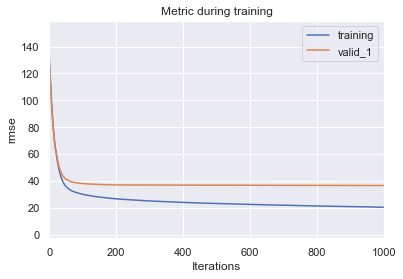

In [50]:
print('Training and Validation Error del Primer Fold')
ax = lgb.plot_metric(evaluations[0], metric='rmse')
plt.show()

Training and Validation Error del Segundo Fold


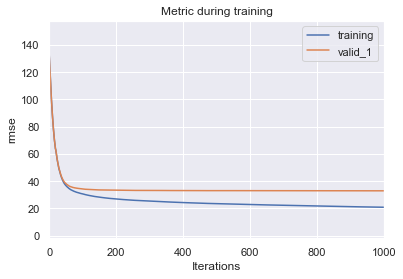

In [51]:
print('Training and Validation Error del Segundo Fold')
ax = lgb.plot_metric(evaluations[1], metric='rmse')
plt.show()

Training and Validation Error del Tercer Fold


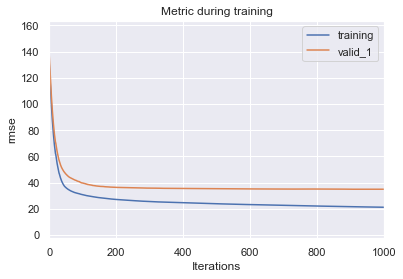

In [52]:
print('Training and Validation Error del Tercer Fold')
ax = lgb.plot_metric(evaluations[2], metric='rmse')
plt.show()

Training and Validation Error del Cuarto Fold


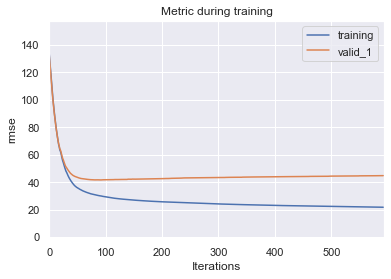

In [53]:
print('Training and Validation Error del Cuarto Fold')
ax = lgb.plot_metric(evaluations[3], metric='rmse')
plt.show()

Busco mejor combinación de hiperparámetros usando hyperopt

In [61]:
''' No logramos encontrar combinación de hiperparámetros que de mejor que la primera configuración.
#! pip install hyperopt

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# objective function to optimize
def objective(params):
    # parameters to perform search
    params = {
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        'n_estimators': int(params['n_estimators'])}
    
    # model and parameters to kept constant
    lgb_model = lgb.LGBMRegressor(
        reg_lambda= 2,
        **params,
        random_state=42)
    
    score = fit_evaluate_model(lgb_model, X_train, y_train, X_test, y_test)
    print("RMSE is {:.4f} with parameters {}".format(score, params))
    return score

# define search space
space = {
    'num_leaves': hp.choice('num_leaves', range(30, 150, 2)),
    'max_depth': hp.uniform('max_depth', 8, 15),
    'learning_rate': hp.uniform('learning_rate', 0.5, 1.5),
    'n_estimators': hp.choice('n_estimators', range(80, 500, 2))
}
#model_lgb = lgb.LGBMRegressor(objective="regression",boosting= "gbdt",metric= "rmse",num_boost_round = 1000,verbose_eval = 100)
SEED = 42
# best model with the hyperopt
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            rstate= np.random.RandomState(SEED))
'''

RMSE is 25.7872 with parameters {'num_leaves': 84, 'max_depth': 13, 'learning_rate': '0.569', 'n_estimators': 162}
RMSE is 28.5278 with parameters {'num_leaves': 122, 'max_depth': 13, 'learning_rate': '1.433', 'n_estimators': 382}
RMSE is 23.1742 with parameters {'num_leaves': 74, 'max_depth': 14, 'learning_rate': '0.803', 'n_estimators': 428}
RMSE is 24.1902 with parameters {'num_leaves': 94, 'max_depth': 14, 'learning_rate': '0.605', 'n_estimators': 218}
RMSE is 25.0740 with parameters {'num_leaves': 120, 'max_depth': 9, 'learning_rate': '1.098', 'n_estimators': 268}
100%|██████████| 5/5 [05:29<00:00, 65.99s/trial, best loss: 23.174241879905892]


El resultado es que no encuentro mejor combinacion de hiperparámetros que el calculo inicial

Calculo predicción para los datos del test

In [24]:
meter_reading_pred = model_lgb.predict(X_nuevos_datos)

In [25]:
X_nuevos_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408240 entries, 0 to 9408239
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   building_id             float64
 1   site_id                 float64
 2   square_feet             float64
 3   air_temperature         float64
 4   cloud_coverage          float64
 5   dew_temperature         float64
 6   precip_depth_1_hr       float64
 7   sea_level_pressure      float64
 8   wind_speed              float64
 9   hour                    float64
 10  day                     float64
 11  weekday                 float64
 12  building_age            float64
 13  wind_compass_direction  float64
dtypes: float64(14)
memory usage: 1004.9 MB


In [26]:
df_nuevo["meter_reading"]=meter_reading_pred

In [27]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [28]:
frames=[df,df_nuevo]

In [29]:
DF_conjunto=pd.concat(frames)

In [30]:
DF_conjunto["timestamp"] = pd.to_datetime(DF_conjunto["timestamp"])

In [31]:
DF_conjunto['year'] = DF_conjunto['timestamp'].dt.year

In [32]:
DF_conjunto['year'].value_counts()

2018    4704120
2017    4704120
2016    3980483
Name: year, dtype: int64

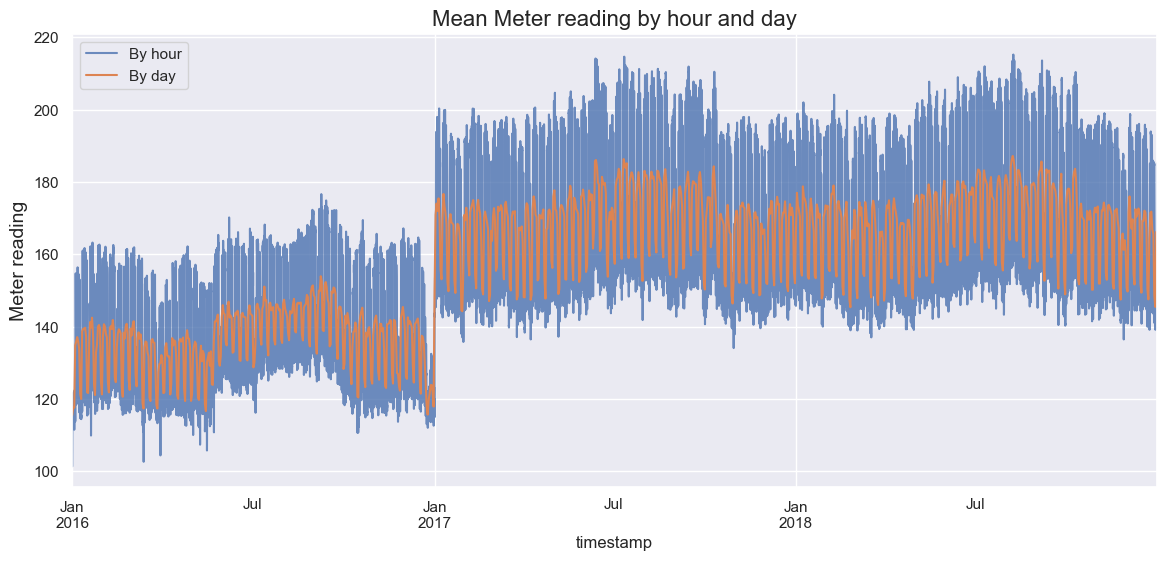

In [33]:
# Promedio de mediciones por dia y por hora de valores reales + predichos

fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
DF_conjunto[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
DF_conjunto[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();